In [1]:
# Upload the Dataset

from google.colab import files
files.upload()


Output hidden; open in https://colab.research.google.com to view.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Define the Dataset

df = pd.read_csv("fake_train.csv")
print(df.head())
print("\nShape :", df.shape)



# Check any Null values present

Null = df.isnull().sum()
print("\n",Null)



# Remove the Null values

df = df.dropna()
print("\n",df.isnull().sum())
print("\nShape :", df.shape)


   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1  

Shape : (20800, 5)

 id           0
title      558
author    1957
text        39
label        0
dtype: int64

 id        0
title     0
author    0

In [3]:
# Removing the unwanted columns

df = df.drop(["id","text","author"], axis=1)
print(df.head())


                                               title  label
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1
1  FLYNN: Hillary Clinton, Big Woman on Campus - ...      0
2                  Why the Truth Might Get You Fired      1
3  15 Civilians Killed In Single US Airstrike Hav...      1
4  Iranian woman jailed for fictional unpublished...      1


In [4]:
import spacy


# Create a function to remove Stop words & Lemmatize it

nlp = spacy.load("en_core_web_sm")

def preprocess(text):

  text = text.lower()
  doc = nlp(text)
  Filtered = []
  for token in doc:
      if token.is_stop or token.is_punct:
          continue
      Filtered.append(token.lemma_)

  return " ".join(Filtered)



# Call the Function


df.title = df.title.apply(preprocess)
print(df.head())


                                               title  label
0   house dem aide comey letter jason chaffetz tweet      1
1   flynn hillary clinton big woman campus breitbart      0
2                                         truth fire      1
3         15 civilian kill single airstrike identify      1
4  iranian woman jail fictional unpublished story...      1


In [6]:
# One Hot Representation

from tensorflow.keras.preprocessing.text import one_hot


voc_size = 5000  #------------------------> Define the Vocabulary size

OHE = [one_hot(word, voc_size) for word in df.title]

OHE


[[3868, 2592, 4687, 480, 3992, 1988, 2805, 653],
 [412, 4398, 3284, 1408, 2416, 3407, 574],
 [4713, 597],
 [1021, 3675, 1623, 3815, 3506, 4235],
 [1816, 2416, 606, 2666, 1409, 144, 2416, 3747, 3875, 1399],
 [548, 166, 958, 1219, 1932, 291, 1422, 2409, 2181, 2687, 3076, 58, 45, 574],
 [2975, 1740, 1839, 1748, 2231, 2235, 1772, 4594, 4357, 2344, 4110],
 [1716, 1868, 2437, 4190, 3125, 1932, 3949, 4357, 2344, 4110],
 [4634, 1632, 3623, 4278, 2051, 89, 1689, 4232, 1932, 2534],
 [2086, 1238, 3950, 4532, 3177, 1593, 2257, 4775],
 [454, 4594, 507, 2597, 4165, 3128, 3606, 2511, 337, 3702, 4549],
 [122, 89, 1932, 4190],
 [2425, 3596, 4661, 763, 997, 4882, 873, 1897, 1643],
 [1965, 2380, 3772, 1360, 3278, 897, 547, 4357, 2344, 4110],
 [2964, 601, 3027, 4172, 4423, 4357, 2344, 4110],
 [3309, 2272, 3596, 3306, 4534, 2986, 515, 368, 1332, 4868, 2797],
 [1494, 730, 4398],
 [3626, 1707, 2263, 4308, 1932, 3943, 811, 574],
 [4065, 1220, 3284, 1757, 3721, 3699, 3162, 2150, 144],
 [2088, 2082, 1932, 1516,

In [7]:
# To Check the Representation

print("Title :",df.title[1])

print("\nOne Hot Representation :", OHE[1])



Title : flynn hillary clinton big woman campus breitbart

One Hot Representation : [412, 4398, 3284, 1408, 2416, 3407, 574]


In [8]:
# Padding - To make all the sentence to same size

from tensorflow.keras.preprocessing.sequence import pad_sequences


sent_size = 20   #------------------------> Define the Sentence size

Embed = pad_sequences(OHE, padding="pre", maxlen=sent_size)
print(Embed)



[[   0    0    0 ... 1988 2805  653]
 [   0    0    0 ... 2416 3407  574]
 [   0    0    0 ...    0 4713  597]
 ...
 [   0    0    0 ... 4357 2344 4110]
 [   0    0    0 ... 1368 4260 2540]
 [   0    0    0 ... 4110 2157 4895]]


In [9]:
# To Check the Padding

print("\nPadding :", Embed[1])



Padding : [   0    0    0    0    0    0    0    0    0    0    0    0    0  412
 4398 3284 1408 2416 3407  574]


In [17]:
# Create a Neural Network

embedding_vector_features = 50   #------------------------> Define the Embedding Vector Features


Model = keras.Sequential([

    keras.layers.Embedding(voc_size, embedding_vector_features),
    keras.layers.Bidirectional(keras.layers.LSTM(100)),
    keras.layers.Dense(1, activation="sigmoid")
])



# Build the model by passing the input shape

Model.build(input_shape=(None, sent_size))


# Compile

Model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])


print(Model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 20, 50)         │       250,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 200)            │       120,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371,001 (1.42 MB)

 Trainable params: 371,001 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

None


In [18]:
# Shape of Title and it's Represntation

print("Shape of Title :",df.title.shape)

print("\nShape of Representation :",Embed.shape)

print("\nShape of Label :", df.label.shape)


Shape of Title : (18285,)

Shape of Representation : (18285, 20)

Shape of Label : (18285,)


In [19]:
# Convert to an Array

x = np.array(Embed)
y = np.array(df.label)

print("Shape of x :", x.shape)
print("Shape of y :", y.shape)


Shape of x : (18285, 20)
Shape of y : (18285,)


In [20]:
# Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (12799, 20)
Shape of X_test: (5486, 20)
Shape of y_train: (12799,)
Shape of y_test: (5486,)


In [21]:
# Train the model

Model.fit(X_train, y_train, epochs=10, validation_data = (X_test, y_test), batch_size = 32)


Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.8311 - loss: 0.3464 - val_accuracy: 0.9183 - val_loss: 0.1923
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9550 - loss: 0.1207 - val_accuracy: 0.9172 - val_loss: 0.1970
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.9751 - loss: 0.0770 - val_accuracy: 0.9163 - val_loss: 0.2619
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.9835 - loss: 0.0531 - val_accuracy: 0.8921 - val_loss: 0.2790
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9904 - loss: 0.0333 - val_accuracy: 0.9087 - val_loss: 0.3467
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9951 - loss: 0.0193 - val_accuracy: 0.9114 - val_loss: 0.4095
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 52ms/step - accuracy: 0.9964 - loss: 0.0134 - val_accuracy: 0.9121 - val_loss: 0.4226
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 37s 43ms/step - accuracy: 0.9962 - loss: 0.0104 - 

In [22]:
# Prediction

y_pred = Model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0) #-------->  Keeping a Threshold


# Evaluate the Model

Evaluate = Model.evaluate(X_test, y_test)
print("Evaluate :", Evaluate)


172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9088 - loss: 0.5367
Evaluate : [0.5225102305412292, 0.9104994535446167]


In [23]:
# Classification Matrix

CR = classification_report(y_test, y_pred)
print("Classification Report :\n\n", CR)


# Confusion Matrix

CM = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix :\n\n", CM)


Classification Report :

               precision    recall  f1-score   support

           0       0.95      0.89      0.92      3107
           1       0.87      0.94      0.90      2379

    accuracy                           0.91      5486
   macro avg       0.91      0.91      0.91      5486
weighted avg       0.91      0.91      0.91      5486


Confusion Matrix :

 [[2763  344]
 [ 147 2232]]


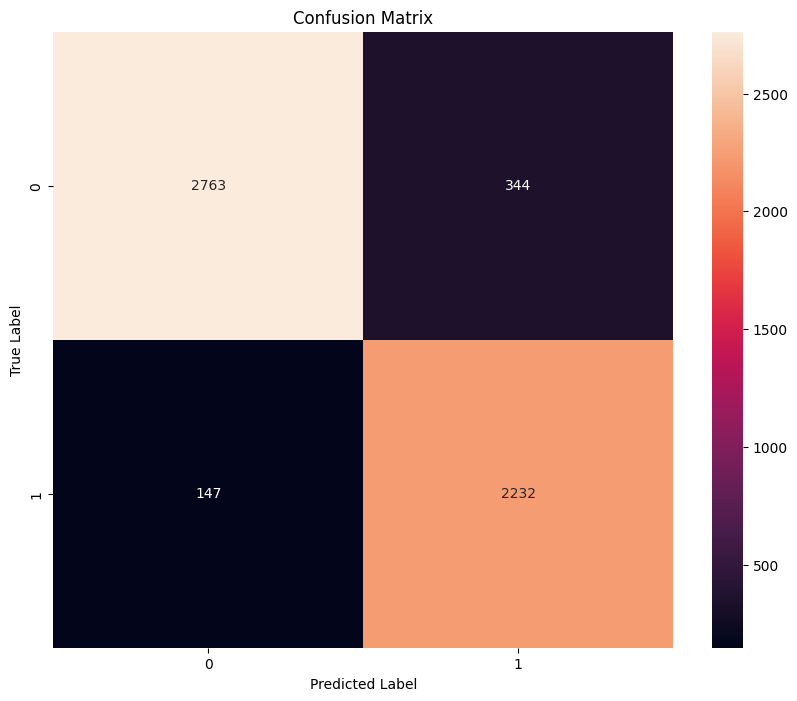

In [28]:
# Plot


plt.figure(figsize=(10,8))
sn.heatmap(CM, annot=True, fmt='d')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()
